# Recognizing Handwritten Digits

In [1]:
from matplotlib import pyplot as plt


In [2]:
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [3]:
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

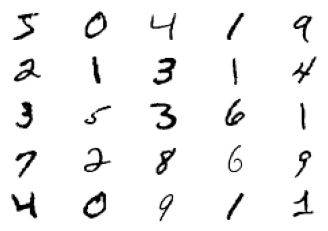

In [5]:
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_train[i], cmap=plt.cm.Greys)
    plt.axis('off')

## Implementing SVM from https://github.com/PantelisKyriakidis/MNIST-with-Keras/blob/master/SVM/svm.py

In [6]:
# Change from matrix to array --> dimension 28x28 to array of dimention 784
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

In [7]:
# Change to float datatype
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [8]:
# Scale the data to lie between -1 to 1
X_train = X_train / 255.0*100 - 50
X_test = X_test / 255.0*100 - 50
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [9]:
# PCA
pca = PCA(n_components=50)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

##  GRID SEARCH FOR PARAMETER OPTIMIZING

In [10]:
svm = SVC()
parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]
                    #{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
print("grid search")
grid = GridSearchCV(svm, parameters, verbose=3)
print("grid.fit")
grid.fit(X_train[0:1000], y_train[0:1000]) #grid search learning the best parameters
print("grid done")

print (grid.best_params_)

grid search
grid.fit
Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.115 total time=   0.6s
[CV 2/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.125 total time=   0.4s
[CV 3/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.125 total time=   0.5s
[CV 4/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.115 total time=   0.3s
[CV 5/5] END ......C=1, gamma=0.001, kernel=rbf;, score=0.115 total time=   0.3s
[CV 1/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.150 total time=   0.4s
[CV 2/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.150 total time=   0.3s
[CV 3/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.175 total time=   0.3s
[CV 4/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.135 total time=   0.3s
[CV 5/5] END .....C=1, gamma=0.0001, kernel=rbf;, score=0.170 total time=   0.3s
[CV 1/5] END .....C=10, gamma=0.001, kernel=rbf;, score=0.115 total time=   0.3s
[CV 2/5] END .....C=10, gamm

In [12]:
#Now we train the best estimator in the full dataset
print("training svm")
best_svm = grid.best_estimator_
best_svm.fit(X_train[0:20000] , y_train[0:20000])
print("svm done")


print("Testing")
print("score: ", best_svm.score(X_test[0:5000], y_test[0:5000],))

training svm
svm done
Testing
score:  0.2354


Now that we have our base model, we can start making a neural network...

## Neural Network for Digit Recognition

In [100]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras import backend as K 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

In [52]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [53]:
# Change from matrix to array --> dimension 28x28 to array of dimention 784
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

In [54]:
# Change to float datatype
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [55]:
# Scale the data to lie between -1 to 1
X_train = X_train / 256
X_test = X_test / 256
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [56]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [57]:
X_train.shape

(60000, 784)

In [94]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [111]:
K.clear_session()
m = Sequential([
    Dense(units=79, activation='softmax', input_shape=(784,)), # Hidden layer
    # units: The number of neurons
    # activation: The activation function used in each neuron
    # input_shape: The input shape of the data
    BatchNormalization(),
    Dropout(0.2),
    Dense(units=40, activation='softmax'),
    BatchNormalization(),
    Dropout(0.5),# Hidden layer
    Dense(units=10, activation='softmax') # Output layer
    # Notice that in the case of the output layer the activation function is determined by the problem
    # we are tackling; in our case we have a binary classification problem which suggests to use 
    # the sigmoid activation function
    
])

In [112]:
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 79)                62015     
_________________________________________________________________
batch_normalization (BatchNo (None, 79)                316       
_________________________________________________________________
dropout (Dropout)            (None, 79)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                3200      
_________________________________________________________________
batch_normalization_1 (Batch (None, 40)                160       
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                4

In [113]:
# To get this running you need to pip install pydot and install graphviz (not a pip installation)

from IPython.display import SVG
from tensorflow.keras.utils import plot_model

plot_model(m,
   #to_file='model.png',
   show_shapes=False,
   show_layer_names=True,
   rankdir='TB', expand_nested=False, dpi=96
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [114]:

m.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [115]:
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 3)
history = m.fit(X_train, y_train, batch_size=120, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
400/400 [==============================] - 3s 6ms/step - loss: 0.6417 - accuracy: 0.8282 - val_loss: 1.6783 - val_accuracy: 0.8848
Epoch 2/100
400/400 [==============================] - 2s 5ms/step - loss: 0.3114 - accuracy: 0.9173 - val_loss: 0.1790 - val_accuracy: 0.9500
Epoch 3/100
400/400 [==============================] - 2s 5ms/step - loss: 0.2476 - accuracy: 0.9326 - val_loss: 0.1451 - val_accuracy: 0.9593
Epoch 4/100
400/400 [==============================] - 2s 5ms/step - loss: 0.2130 - accuracy: 0.9428 - val_loss: 0.1334 - val_accuracy: 0.9625
Epoch 5/100
400/400 [==============================] - 2s 5ms/step - loss: 0.1914 - accuracy: 0.9485 - val_loss: 0.1244 - val_accuracy: 0.9637
Epoch 6/100
400/400 [==============================] - 2s 5ms/step - loss: 0.1731 - accuracy: 0.9526 - val_loss: 0.1171 - val_accuracy: 0.9676
Epoch 7/100
400/400 [==============================] - 2s 5ms/step - loss: 0.1541 - accuracy: 0.9576 - val_loss: 0.1101 - val_accuracy: 0.9683

In [ ]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

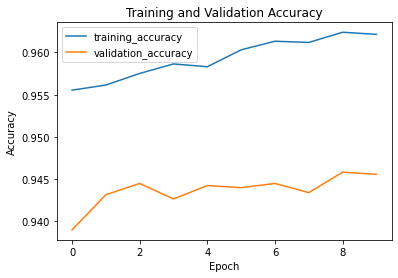

In [66]:
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
m.evaluate(X, y)

In [31]:
# Look at the first 10 predictions
m.predict(X_test)[:10]

array([[2.7888555e-03, 2.9609937e-03, 6.6008084e-03, 1.3360545e-02,
        1.9225704e-02, 5.2227699e-03, 2.9235356e-04, 4.9820197e-01,
        8.6555732e-03, 4.4269046e-01],
       [6.2855552e-03, 9.4426628e-03, 9.0686357e-01, 3.2940477e-02,
        4.4105332e-03, 6.0510286e-03, 6.5392163e-03, 1.3222815e-02,
        1.1165771e-02, 3.0783499e-03],
       [4.1179785e-05, 9.6056652e-01, 4.8217680e-03, 2.9138695e-03,
        2.3821101e-03, 2.7889505e-03, 1.6525120e-03, 4.1985339e-03,
        1.8503144e-02, 2.1315345e-03],
       [6.1363703e-01, 2.0975138e-04, 1.0688342e-02, 1.4479800e-02,
        7.9507596e-04, 3.2701272e-01, 1.1255840e-02, 2.8014325e-03,
        1.2046192e-02, 7.0737242e-03],
       [2.8015671e-03, 1.9032923e-03, 2.8925370e-02, 2.0336846e-03,
        8.8083082e-01, 8.2746083e-03, 6.5125651e-03, 9.6777799e-03,
        7.2495490e-03, 5.1790755e-02],
       [4.1179785e-05, 9.6056652e-01, 4.8217680e-03, 2.9138695e-03,
        2.3821101e-03, 2.7889505e-03, 1.6525120e-03, 4.19

In [31]:
# Inspect the weights of the Neural Network
m.get_weights()[0]

# Input weights

array([[ 1.3456134 ,  0.00848617],
       [-0.71513504,  0.05879356]], dtype=float32)

# More Advanced CNN Model

In [ ]:
K.clear_session()
model = keras.models.Sequential()
# first convolutional block
# add a convolutional layer with 32 units and a 3x3 kernel
# add a MaxPooling2D layer with a pool size of 2x2
model.add(keras.layers.Conv2D(filters=64,
                            padding='same',
                            activation ='relu',
                            kernel_size=(3,3),
                            input_shape=(28, 28, 1) # rows, cols, color channels
                            ))
model.add(keras.layers.Conv2D(filters=64,
                            padding='same',
                            activation ='relu',
                            kernel_size=(3,3)
                            ))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.Dropout(0.2))

# second convolutional block
# add a convolutional layer with 64 units and a 3x3 kernel
# add a MaxPooling2D layer with pool size of 2x2
model.add(keras.layers.Conv2D(filters=32,
                            padding='same',
                            activation ='relu',
                            kernel_size=(3,3)
                            ))
model.add(keras.layers.Conv2D(filters=32,
                            padding='same',
                            activation ='relu',
                            kernel_size=(3,3)
                            ))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
#model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.Dropout(0.5))


#third convolutional block
#add a convolutional layer with 64 units and a 3x3 kernel
model.add(keras.layers.Conv2D(filters=32,
                            padding='same',
                            activation ='relu',
                            kernel_size=(3,3)
                            ))
model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
#model.add(keras.layers.BatchNormalization())
#model.add(keras.layers.Dropout(0.5))


#final dense block
#add a layer that flattens the output
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(64, activation='relu'))

# add a dense layer with 64 units
model.add(keras.layers.Dense(64, activation='relu'))
#model.add(keras.layers.BatchNormalization()) 
#model.add(keras.layers.Dropout(0.5)) - this breaks the validation accuracy

#add a dense output layer with 10 units and softmax activation
model.add(keras.layers.Dense(10, activation='softmax'))




In [ ]:
model.summary()

In [23]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
results = model.fit(X_test_reshaped, y_test_reshaped, epochs=10, batch_size=200, validation_split=0.1)

Epoch 1/10
45/45 [==============================] - 88s 2s/step - loss: 0.9702 - accuracy: 0.6743 - val_loss: 1.7545 - val_accuracy: 0.7900
Epoch 2/10
45/45 [==============================] - 78s 2s/step - loss: 0.1992 - accuracy: 0.9372 - val_loss: 1.4768 - val_accuracy: 0.8850
Epoch 3/10
45/45 [==============================] - 84s 2s/step - loss: 0.1389 - accuracy: 0.9571 - val_loss: 1.1819 - val_accuracy: 0.9400
Epoch 4/10
45/45 [==============================] - 70s 2s/step - loss: 0.0803 - accuracy: 0.9759 - val_loss: 0.7155 - val_accuracy: 0.9670
Epoch 5/10
45/45 [==============================] - 65s 1s/step - loss: 0.0614 - accuracy: 0.9794 - val_loss: 0.7267 - val_accuracy: 0.9130
Epoch 6/10
45/45 [==============================] - 61s 1s/step - loss: 0.0424 - accuracy: 0.9861 - val_loss: 0.3025 - val_accuracy: 0.9660
Epoch 7/10
45/45 [==============================] - 63s 1s/step - loss: 0.0383 - accuracy: 0.9870 - val_loss: 0.1756 - val_accuracy: 0.9760
Epoch 8/10


KeyboardInterrupt: 

In [12]:
# calculate the accuracy 
results.history['val_accuracy']

[0.8510000109672546,
 0.9549999833106995,
 0.9779999852180481,
 0.9649999737739563,
 0.9789999723434448]

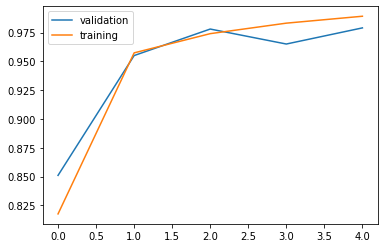

In [13]:
#plot a curve of the training and validation loss
plt.plot(results.history['val_accuracy'], label='validation')
plt.plot(results.history['accuracy'], label='training')
plt.legend()

In [14]:
y_pred = model.evaluate(X_test_reshaped, y_test_reshaped)

313/313 [==============================] - 10s 31ms/step - loss: 0.0306 - accuracy: 0.9891


# Using a pretrained Model